In [1]:
import shap
import keras
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Input, Dropout, LSTM, GlobalAveragePooling1D, MultiHeadAttention
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

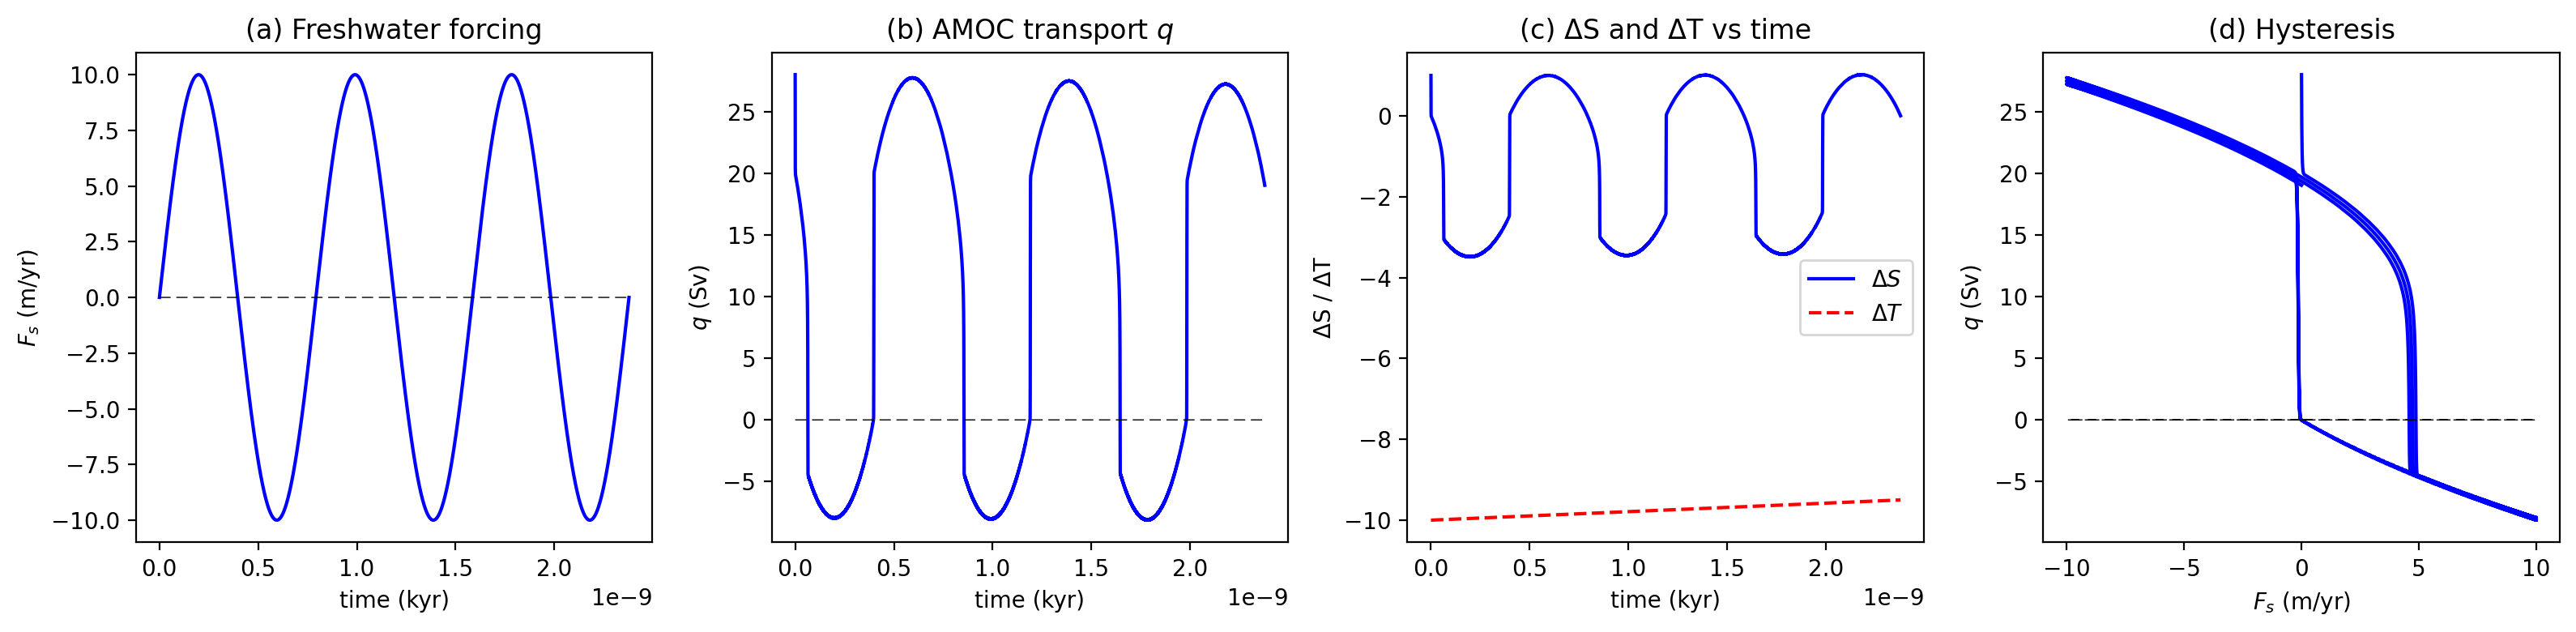

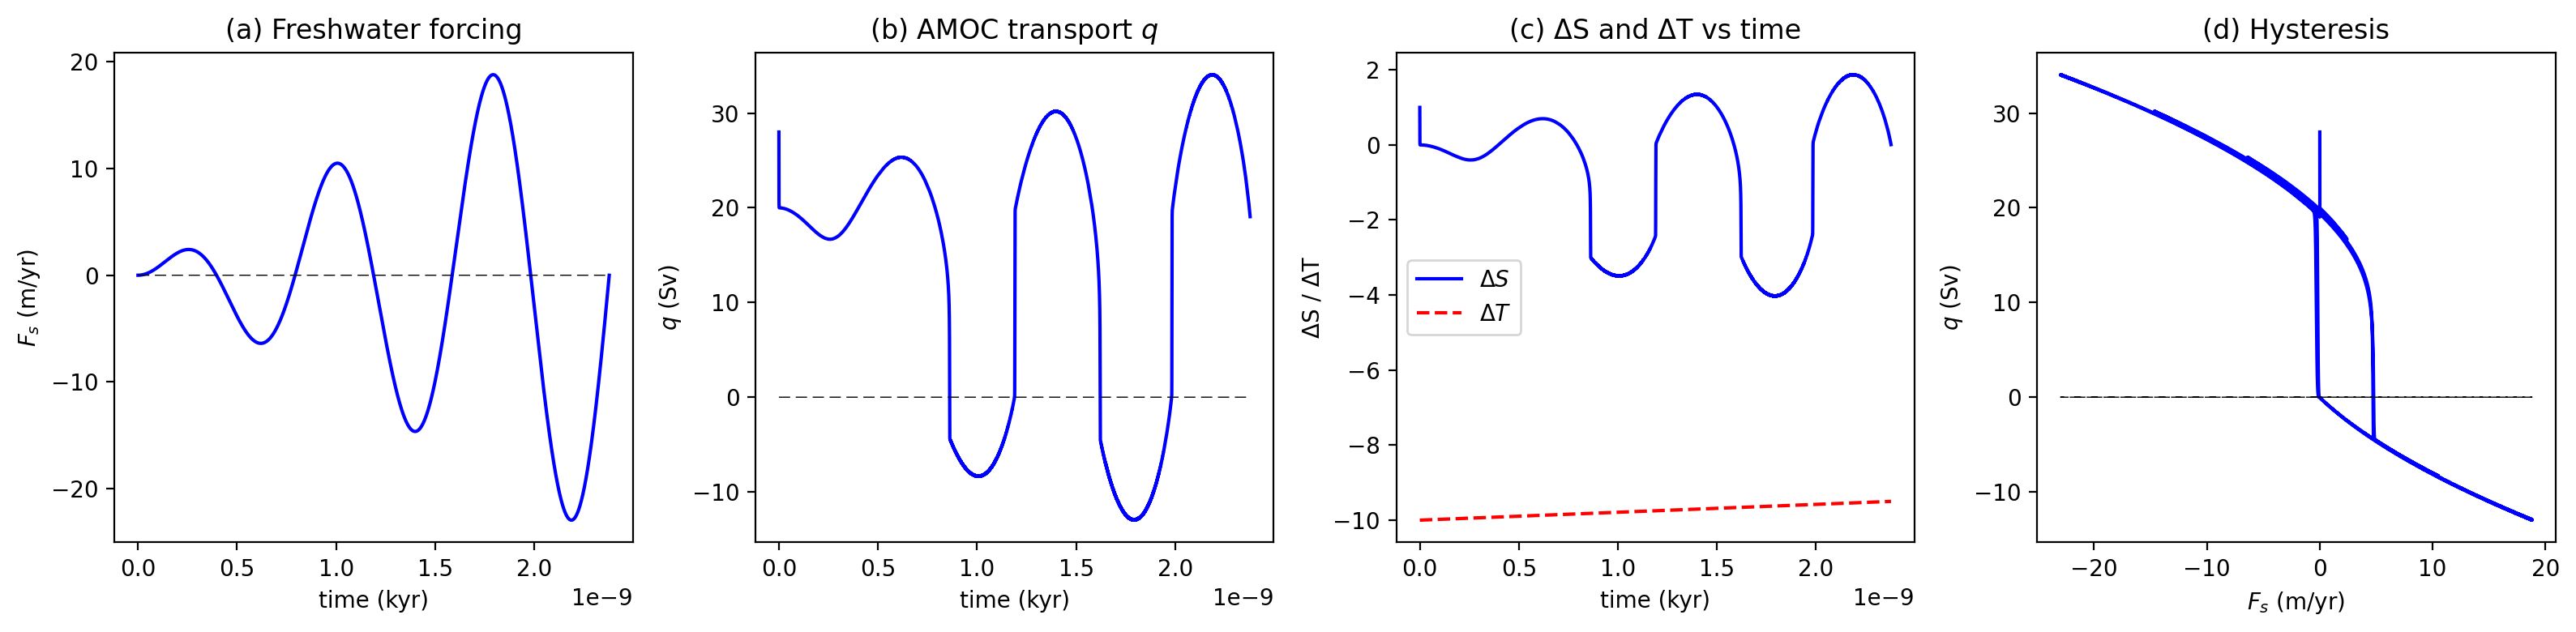

In [2]:
%run 00_generate_data.ipynb

In [3]:
def data_for_shap(forcing_type):
    
    # getting data
    input_data, output_data, qplot = get_data(forcing_type)
    X_train = input_data[0:60032]
    y_train = output_data[0:60032]
    X_val = input_data[61024:81000]
    y_val = output_data[61024:81000]
    X_test = input_data[81992:100000]
    y_test = output_data[81992:100000]
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    input_scaled = scaler.transform(input_data)
    
    # data for SHAP
    background_data = shap.kmeans(X_train_scaled, 50)
    
    # for reproducibility
    rng = np.random.default_rng(seed=42)
    qplot_smooth = qplot / Sv
    q_gradient = np.abs(np.gradient(qplot_smooth))
    gradient_probs = q_gradient / q_gradient.sum()
    sample_size = 1000
    sample_indices = rng.choice(len(qplot), size=sample_size, replace=False, p=gradient_probs)
    input_sample = input_scaled[sample_indices]
    
    return background_data, input_sample, sample_indices

def create_sequences(data, labels, time_steps):
    sequences, sequence_labels = [], []
    for i in range(len(data) - time_steps + 1):
        sequences.append(data[i:i + time_steps])
        sequence_labels.append(labels[i + time_steps - 1])  # Label at the end of the sequence
    return np.array(sequences), np.array(sequence_labels)

def data_for_shap_ts(forcing_type, model_type):
    
    if forcing_type == "s":
        time_steps = 16
    else:
        if model_type == "lstm":
            time_steps = 32
        else:
            time_steps = 64
            
    # getting data
    input_data, output_data, qplot = get_data(forcing_type)
    X_train = input_data[0:60032]
    y_train = output_data[0:60032]
    X_val = input_data[61024:81000]
    y_val = output_data[61024:81000]
    X_test = input_data[81992:100000]
    y_test = output_data[81992:100000]
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    input_scaled = scaler.transform(input_data)

    # Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
    X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, time_steps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)
    input_seq, output_seq = create_sequences(input_scaled, output_data, time_steps)
    
    num_sequences = input_seq.shape[0]
    
    # data for SHAP
    background_data = shap.kmeans(X_train_seq.reshape(X_train_seq.shape[0], -1), 10)
    
    # for reproducibility
    rng = np.random.default_rng(seed=42)
    qplot_smooth = qplot / Sv
    seq_grad = np.array([
    np.mean(np.abs(np.gradient(qplot_smooth[i:i+time_steps])))
    for i in range(num_sequences)
    ])
    seq_probs = seq_grad / seq_grad.sum()
    sample_size = 1000
    sample_start_indices = rng.choice(num_sequences, size=sample_size, replace=False, p=seq_probs)

    input_sample = input_seq[sample_start_indices]
    
    return background_data, input_sample, sample_start_indices

In [4]:
def build_transformer():
    inputs = Input(shape=(None, 4))  # None allows variable sequence length
    
   
    attention_output = MultiHeadAttention(
        num_heads=4,
        key_dim=4,
        dropout=0.1
    )(inputs, inputs)  

    pooled = GlobalAveragePooling1D()(attention_output)

    x = Dense(16, activation='relu')(pooled)
    x = Dense(8, activation='relu')(x)
    x = Dense(4, activation='relu')(x)
    x = Dense(2, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model 

def get_models(forcing_type, model_type):
    forcing = "stationary"
    if forcing_type == "ns":
        forcing = "nonstationary"
    
    if forcing_type == "s":
        time_steps = 16
    else:
        if model_type == "lstm":
            time_steps = 32
        else:
            time_steps = 64
            
    models = []
    if model_type == "mlp":
        for i in range(12):
            model = Sequential()
            model.add(Dense(4, input_dim=4, activation='relu'))
            model.add(Dense(2, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.load_weights(f'models/{model_type}/{forcing}/ensemble_member_{i}.keras')
            models.append(model)
    elif model_type == "lstm":
        for i in range(12):
            model = Sequential([
            LSTM(8, input_shape=(time_steps, 4), return_sequences=False),
            Dense(4, activation='relu'),
            Dense(2, activation='relu'),
            Dense(1, activation='sigmoid') 
            ])
            model.load_weights(f'models/{model_type}/{forcing}/ensemble_member_{i}.keras')
            models.append(model)
    elif model_type == "transformer":
        for i in range(12):
            model = build_transformer()
            model.load_weights(f'models/{model_type}/{forcing}/ensemble_member_{i}.keras')
            models.append(model)
        
    return models

In [5]:
def generate_shap_vals(forcing_type, model_type):
    
    models = get_models(forcing_type, model_type)
    shap_vals = []
    feature_names = ['Time', 'Salinity Difference', 'Temperature Difference', 'Freshwater Forcing']
    
    time_steps = 16
    if forcing_type == "ns":
        if model_type == "lstm":
            time_steps = 32
        else:
            time_steps = 64
            
    if model_type == "mlp":
        background_data, input_sample, sample_indices = data_for_shap(forcing_type)
        for i, model in enumerate(models):
            print(f"Computing SHAP for model {i}")
            explainer = shap.KernelExplainer(model.predict, background_data, feature_names=feature_names, num_samples=100)
            shap_values = explainer.shap_values(input_sample)
            shap_vals.append(shap_values)
    else:
        background_data, input_sample, sample_start_indices = data_for_shap_ts(forcing_type, model_type)
        input_samples_flat = input_sample.reshape(input_sample.shape[0], -1)
        def predict_flattened(X):
                X_reshaped = X.reshape(X.shape[0], time_steps, 4)
                return model.predict(X_reshaped)
        for i, model in enumerate(models):
            print(f"Computing SHAP for model {i}")
            explainer = shap.KernelExplainer(predict_flattened, background_data, feature_names=feature_names, num_samples=100)
            shap_values = explainer.shap_values(input_samples_flat)
            np.save(f'shap_npy/shap_transformer_{i}', shap_values)
            shap_vals.append(shap_values)
    
    return np.array(shap_vals)

In [6]:
shap_transformer_ns = generate_shap_vals("ns", "transformer")
np.save('shap_npy/shap_transformer_ns', shap_transformer_ns)

Computing SHAP for model 0
1/1 [==============================] - 0s 297ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 19ms/step


800/800 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 18ms/step


800/800 [==============================] - 3s 3ms/step


1/1 [==============================] - 0s 14ms/step


800/800 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 18ms/step


800/800 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 16ms/step


800/800 [==============================] - 2s 2ms/step
Computing SHAP for model 1
1/1 [==============================] - 0s 78ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


800/800 [==============================] - 3s 3ms/step


1/1 [==============================] - 0s 18ms/step


800/800 [==============================] - 3s 3ms/step


1/1 [==============================] - 0s 17ms/step


800/800 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 18ms/step


800/800 [==============================] - 3s 3ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 19ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 16ms/step


800/800 [==============================] - 2s 2ms/step
Computing SHAP for model 2
1/1 [==============================] - 0s 75ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


800/800 [==============================] - 3s 4ms/step


1/1 [==============================] - 0s 16ms/step


800/800 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 14ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 14ms/step


800/800 [==============================] - 3s 3ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 18ms/step


800/800 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 18ms/step


800/800 [==============================] - 2s 3ms/step
Computing SHAP for model 3
1/1 [==============================] - 0s 95ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


800/800 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 14ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 19ms/step


800/800 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 16ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 16ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 14ms/step


800/800 [==============================] - 2s 2ms/step
Computing SHAP for model 4
1/1 [==============================] - 0s 78ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 19ms/step


800/800 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 18ms/step


800/800 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 17ms/step


800/800 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


800/800 [==============================] - 2s 2ms/step
Computing SHAP for model 5
1/1 [==============================] - 0s 79ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 14ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 14ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 14ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step
Computing SHAP for model 6
1/1 [==============================] - 0s 75ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 14ms/step


800/800 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 16ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 14ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 14ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 14ms/step


800/800 [==============================] - 2s 2ms/step
Computing SHAP for model 7
1/1 [==============================] - 0s 78ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 13ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 17ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step
Computing SHAP for model 8
1/1 [==============================] - 0s 85ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 14ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 16ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 17ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step
Computing SHAP for model 9
1/1 [==============================] - 0s 76ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 17ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 14ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step
Computing SHAP for model 10
1/1 [==============================] - 0s 80ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 16ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 14ms/step


800/800 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step
Computing SHAP for model 11
1/1 [==============================] - 0s 80ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 17ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 15ms/step


800/800 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 14ms/step


800/800 [==============================] - 2s 2ms/step


In [13]:
shap_transformer_ns.shape

NameError: name 'shap_transformer_ns' is not defined

In [31]:
shap_ns = np.load('shap_npy/shap_lstm_ns.npy')

In [36]:
shap_ns.squeeze().reshape(12, 250, 32, 4).mean(axis=(0, 2)).shape

(250, 4)

In [37]:
lrp_sal_mean = shap_ns.squeeze().reshape(12, 250, 32, 4).mean(axis=(0, 2))[:, 1]
lrp_temp_mean = shap_ns.squeeze().reshape(12, 250, 32, 4).mean(axis=(0, 2))[:, 2]

In [29]:
background_data, input_sample, sample_indices = data_for_shap("ns")

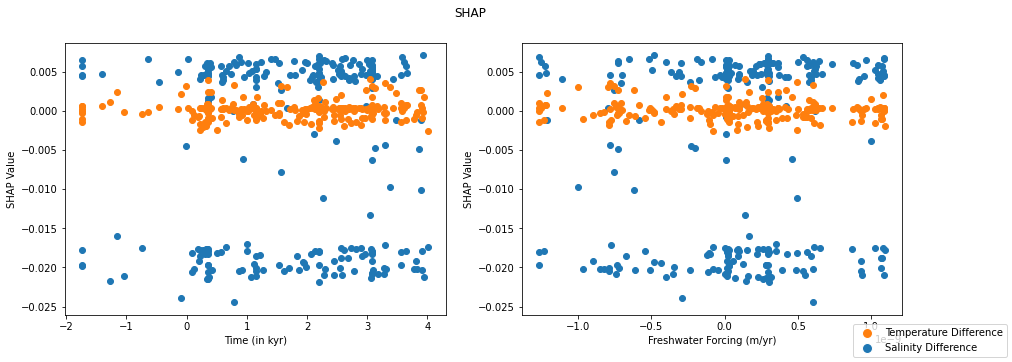

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('SHAP')

ax[0].scatter(input_sample[:, 0], lrp_sal_mean)
ax[0].scatter(input_sample[:, 0], lrp_temp_mean)
ax[1].scatter(input_sample[:, 3]/Fs_to_m_per_year, lrp_sal_mean)
ax[1].scatter(input_sample[:, 3]/Fs_to_m_per_year, lrp_temp_mean)
ax[0].set_xlabel('Time (in kyr)')
ax[0].set_ylabel('SHAP Value')
ax[1].set_xlabel('Freshwater Forcing (m/yr)')
ax[1].set_ylabel('SHAP Value')
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor='#ff7f0e', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor='#1f77b4', markersize=10)
]
fig.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
           loc='lower right')

In [25]:
np.save('shap_npy/shap_mlp_s.npy', shap_s)

In [3]:
input_data, output_data, qplot = get_data("ns")

In [4]:
X_train = input_data[0:60032]
y_train = output_data[0:60032]

X_val = input_data[61024:81000]
y_val = output_data[61024:81000]

X_test = input_data[81992:100000]
y_test = output_data[81992:100000]

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

In [5]:
background_data = shap.kmeans(X_train_scaled, 50)
shap_values_list = []
feature_names = ['Time', 'Salinity Difference', 'Temperature Difference', 'Freshwater Forcing']

In [10]:
models = []
for i in range(12):
    model = Sequential()
    model.add(Dense(4, input_dim=4, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.load_weights(f'models/mlp/nonstationary/ensemble_member_{i}.keras')
    models.append(model)

In [11]:
# More samples where AMOC changes rapidly (derivatives)
qplot_smooth = qplot/Sv
q_gradient = np.abs(np.gradient(qplot_smooth))

# Higher sampling probability where gradient is high
gradient_probs = q_gradient / q_gradient.sum()
sample_indices = np.random.choice(len(qplot), size=250, replace=False, p=gradient_probs)
input_sample = input_scaled[sample_indices]

In [12]:
for i, model in enumerate(models):
    print(f"Computing SHAP for model {i}")
    explainer = shap.KernelExplainer(model.predict, background_data, feature_names=feature_names)
    shap_values = explainer.shap_values(input_sample)
    shap_values_list.append(shap_values)

Computing SHAP for model 0
2/2 [==============================] - 0s 2ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

22/22 [==============================] - 0s 862us/step


22/22 [==============================] - 0s 920us/step


22/22 [==============================] - 0s 802us/step
Computing SHAP for model 1
2/2 [==============================] - 0s 2ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

22/22 [==============================] - 0s 819us/step


22/22 [==============================] - 0s 873us/step
Computing SHAP for model 2
2/2 [==============================] - 0s 2ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

22/22 [==============================] - 0s 853us/step


22/22 [==============================] - 0s 1ms/step
Computing SHAP for model 3
2/2 [==============================] - 0s 2ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

22/22 [==============================] - 0s 773us/step


22/22 [==============================] - 0s 834us/step
Computing SHAP for model 4
2/2 [==============================] - 0s 2ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

22/22 [==============================] - 0s 948us/step


22/22 [==============================] - 0s 995us/step
Computing SHAP for model 5
2/2 [==============================] - 0s 2ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

22/22 [==============================] - 0s 945us/step


22/22 [==============================] - 0s 886us/step
Computing SHAP for model 6
2/2 [==============================] - 0s 2ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

22/22 [==============================] - 0s 872us/step


22/22 [==============================] - 0s 848us/step
Computing SHAP for model 7
2/2 [==============================] - 0s 2ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

22/22 [==============================] - 0s 1ms/step


22/22 [==============================] - 0s 871us/step
Computing SHAP for model 8
2/2 [==============================] - 0s 2ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

22/22 [==============================] - 0s 958us/step


22/22 [==============================] - 0s 804us/step
Computing SHAP for model 9
2/2 [==============================] - 0s 2ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

22/22 [==============================] - 0s 897us/step


22/22 [==============================] - 0s 960us/step
Computing SHAP for model 10
2/2 [==============================] - 0s 2ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

22/22 [==============================] - 0s 937us/step


22/22 [==============================] - 0s 934us/step
Computing SHAP for model 11
2/2 [==============================] - 0s 3ms/step


  0%|          | 0/250 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


22/22 [==============================] - 0s 1ms/step


In [13]:
shap_values_list_np = np.array(shap_values_list)

In [14]:
len(shap_values_list)

12

In [18]:
#np.save('shap_mlp_ns', shap_values_list_np)

In [15]:
shap_ensemble_mean = np.array(shap_values_list).squeeze(axis=1).mean(axis=0)

In [16]:
raw_input_sample = input_data[sample_indices]
qsample = qplot[sample_indices]

In [17]:
shap_ensemble_mean.shape

(250, 4)

In [18]:
shap_temp_mean = shap_ensemble_mean[:, 2]
shap_sal_mean = shap_ensemble_mean[:, 1]

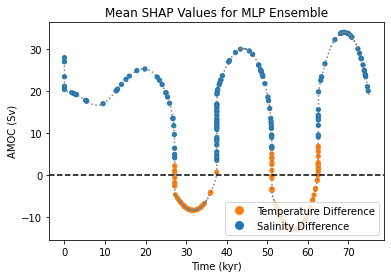

In [19]:
fig, ax = plt.subplots()

# Create color array
colors = np.where(shap_temp_mean > shap_sal_mean, '#ff7f0e', '#1f77b4')

# Single scatter call
scatter = ax.scatter(raw_input_sample[:, 0], qsample/Sv, 
                    c=colors, marker='o', s=18)

ax.set_xlabel('Time (kyr)')
ax.set_ylabel('AMOC (Sv)')
ax.set_title('Mean SHAP Values for MLP Ensemble')
ax.plot(input_data[:, 0], qplot/Sv, linestyle=':', color='grey')
ax.axhline(0, color='black', linestyle='--')

# Manual legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#ff7f0e', markersize=10),
                 plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#1f77b4', markersize=10)]
ax.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
          loc='lower right')

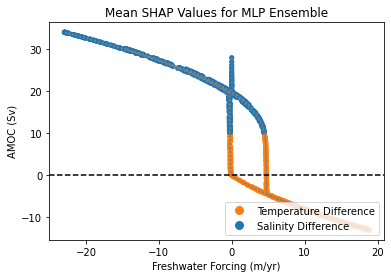

In [23]:
fig, ax = plt.subplots()

# Create color array
colors = np.where(shap_temp_mean > shap_sal_mean, '#ff7f0e', '#1f77b4')

# Single scatter call
scatter = ax.scatter(raw_input_sample[:, 3]/Fs_to_m_per_year, qsample/Sv, 
                    c=colors, marker='o', s=18)

ax.set_xlabel('Freshwater Forcing (m/yr)')
ax.set_ylabel('AMOC (Sv)')
ax.set_title('Mean SHAP Values for MLP Ensemble')
ax.plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv, linestyle=':', color='grey')
ax.axhline(0, color='black', linestyle='--')

# Manual legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#ff7f0e', markersize=10),
                 plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#1f77b4', markersize=10)]
ax.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
          loc='lower right')

In [24]:
opposite_idx = np.where(shap_temp_mean * shap_sal_mean < 0)[0]
same_sign_idx = np.where(shap_temp_mean * shap_sal_mean > 0)[0]

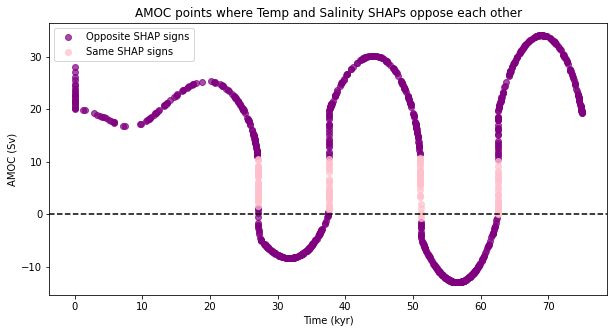

In [25]:
plt.figure(figsize=(10,5))
plt.scatter(raw_input_sample[opposite_idx, 0], qsample[opposite_idx]/Sv,
            color='purple', marker='o', alpha=0.7, label='Opposite SHAP signs')
plt.scatter(raw_input_sample[same_sign_idx, 0], qsample[same_sign_idx]/Sv,
            color='pink', marker='o', alpha=0.7, label='Same SHAP signs')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Time (kyr)")
plt.ylabel("AMOC (Sv)")
plt.title("AMOC points where Temp and Salinity SHAPs oppose each other")
plt.legend()
plt.show()


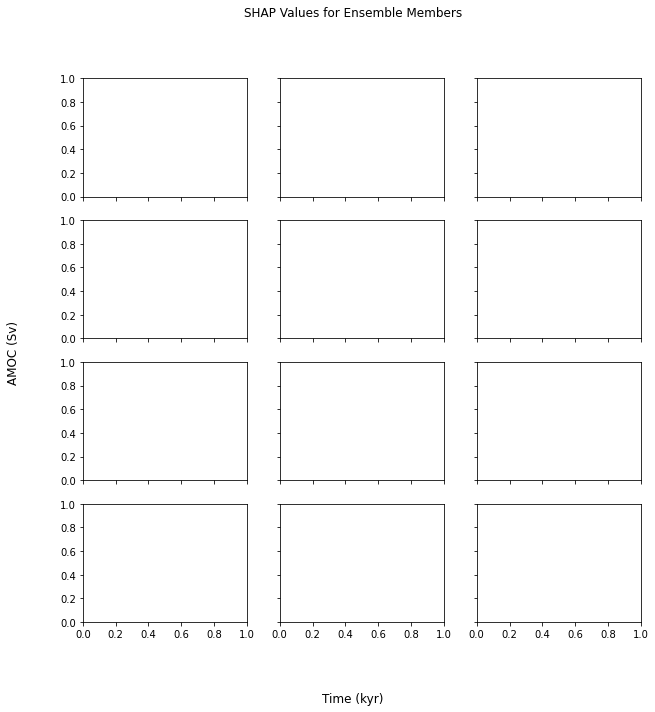

In [26]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Time (kyr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('SHAP Values for Ensemble Members')
ax = ax.flatten()

In [28]:
for i in range(12):
    shap_i = np.array(shap_values_list_np)[i, 0, :, :]
    shap_temp = shap_i[:, 2]
    shap_sal = shap_i[:, 1]
    colors = np.where(shap_temp > shap_sal, '#ff7f0e', '#1f77b4')

    scatter = ax[i].scatter(raw_input_sample[:, 0], qsample/Sv, 
                            c=colors, marker='o', s=18, alpha=0.5)
    ax[i].plot(input_data[:, 0], qplot/Sv, linestyle=':', color='grey')
    ax[i].axhline(0, color='black', linestyle='--')

# After the loop: figure-level legend
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor='#ff7f0e', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor='#1f77b4', markersize=10)
]
fig.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
           loc='lower right')

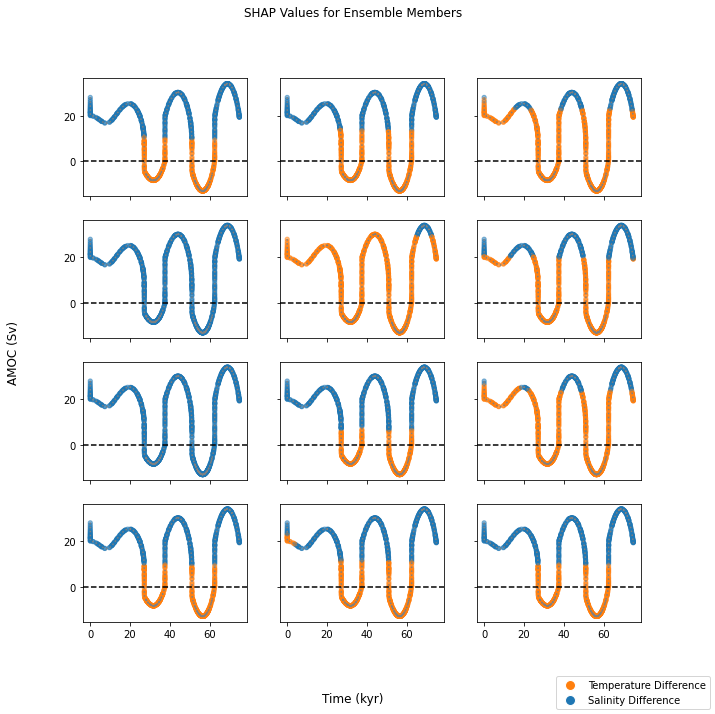

In [29]:
fig

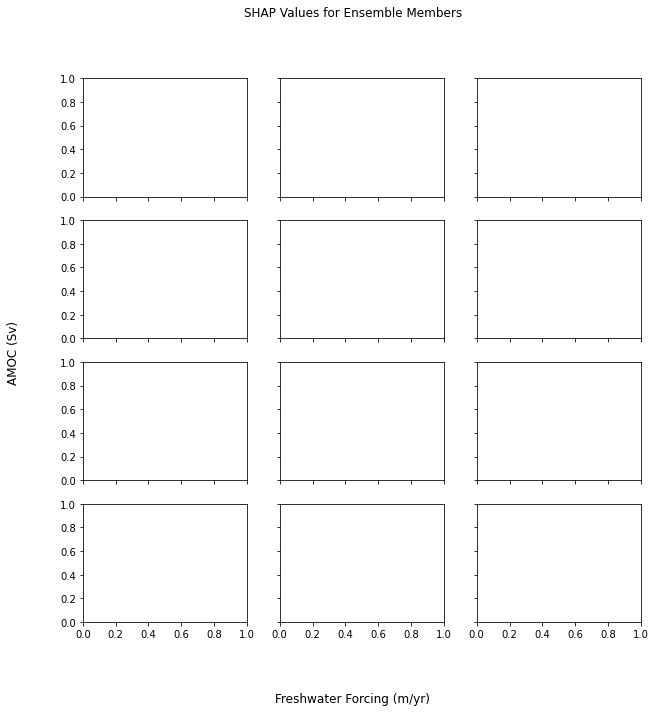

In [30]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Freshwater Forcing (m/yr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('SHAP Values for Ensemble Members')
ax = ax.flatten()

In [31]:
for i in range(12):
    shap_i = np.array(shap_values_list_np)[i, 0, :, :]
    shap_temp = shap_i[:, 2]
    shap_sal = shap_i[:, 1]
    colors = np.where(shap_temp > shap_sal, '#ff7f0e', '#1f77b4')

    scatter = ax[i].scatter(raw_input_sample[:, 3]/Fs_to_m_per_year, qsample/Sv, 
                            c=colors, marker='o', s=18, alpha=0.5)
    ax[i].plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv, linestyle=':', color='grey')
    ax[i].axhline(0, color='black', linestyle='--')

# After the loop: figure-level legend
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor='#ff7f0e', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor='#1f77b4', markersize=10)
]
fig.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
           loc='lower right')

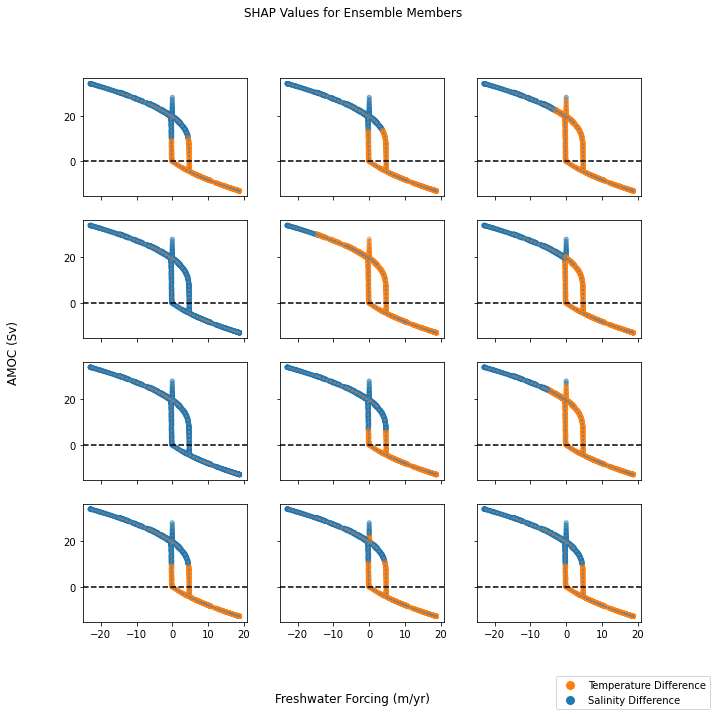

In [32]:
fig